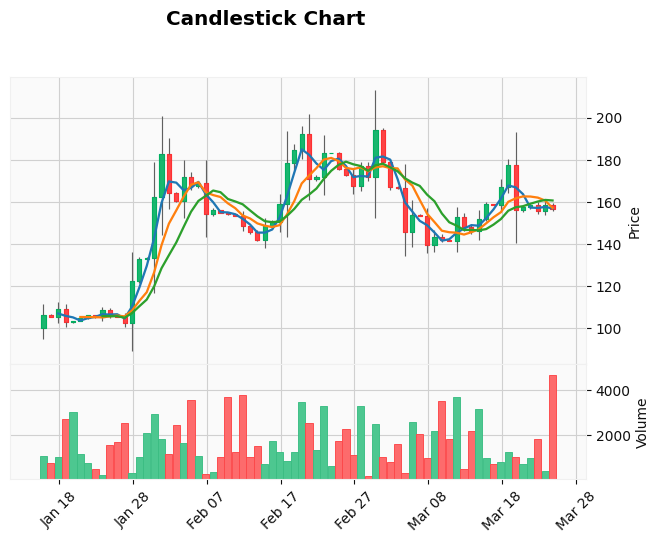

In [1]:
import numpy as np
import random
from datetime import datetime
import mplfinance as mpf
import pandas as pd
import pickle


def generate_random_candlestick_data(
        num_candles, initial_price=100, min_volatility=0.01, max_volatility=0.1,
        max_shadow_amplitude=0.9, max_volume_multiplier=5.0, start_date=None):

    open_prices = np.zeros(num_candles)
    high_prices = np.zeros(num_candles)
    low_prices = np.zeros(num_candles)
    close_prices = np.zeros(num_candles)
    volumes = np.zeros(num_candles)
    if start_date is None:
        start_date = datetime.now()
    volatilities = np.random.uniform(min_volatility, max_volatility, num_candles)

    for i in range(num_candles):
        open_prices[i] = initial_price
        price_movement = np.random.normal(0, volatilities[i] * initial_price)
        close_prices[i] = open_prices[i] + price_movement
        # Calculate shadow amplitude as a percentage of the candle body
        shadow_amplitude = np.random.uniform(0, max_shadow_amplitude) * abs(price_movement)
        high_prices[i] = max(open_prices[i], close_prices[i]) + shadow_amplitude
        low_prices[i] = min(open_prices[i], close_prices[i]) - shadow_amplitude
        # Generate a base volume and apply a multiplier to create variations
        base_volume = random.randint(100, 1000)
        volumes[i] = base_volume * np.random.uniform(1.0, max_volume_multiplier)
        # Set the initial price for the next candle to the close price of the current candle.
        initial_price = close_prices[i]

    candlestick_data = np.column_stack((open_prices, high_prices, low_prices, close_prices, volumes))
    return candlestick_data, start_date


def plot_candlestick_chart(candlestick_data, start_date, title="Candlestick Chart"):

    candlestick_data = pd.DataFrame(candlestick_data, columns=["Open", "High", "Low", "Close", "Volume"],
                                    index=pd.date_range(start_date, periods=len(candlestick_data), freq="D"))
    mpf.plot(candlestick_data, type="candle", mav=(3, 6, 9), volume=True, show_nontrading=True, style="yahoo", title=title)

if __name__== "__main__":
    candlestick_data, start_date = generate_random_candlestick_data(num_candles=70)
    plot_candlestick_chart(candlestick_data, start_date, title="Candlestick Chart")

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


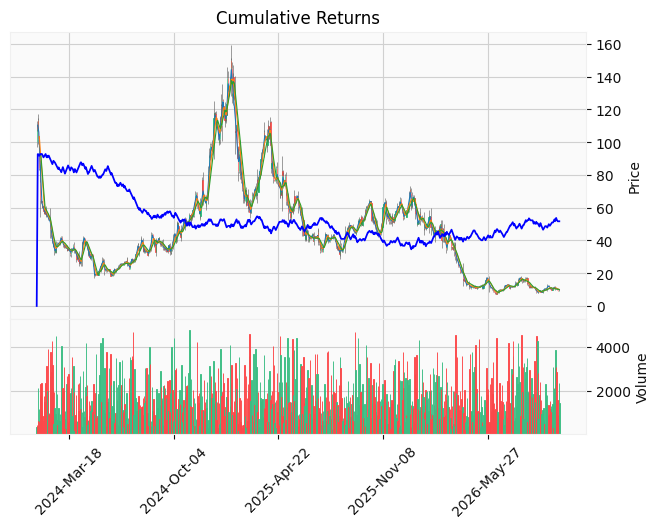

In [2]:
from gymnasium import spaces
import numpy as np
import pandas as pd
# from random_walk_ohlc import generate_random_candlestick_data
import mplfinance as mpf
from datetime import datetime
import gymnasium as gym



class TradingEnvironment(gym.Env):
    def __init__(self, candlestick_data, initial_balance=1):
        super(TradingEnvironment, self). __init__()

        self.candlestick_data = candlestick_data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.current_step = 0
        self.current_position = 0
        self.max_position = 1 

        self.action_space = spaces.Discrete(3) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,)) 

        self.balances_history = []
        self.prices_history = []

       
    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.current_position = 0
        self.balances_history = []
        self.prices_history = []
        return self._next_observation()
    def _next_observation(self):
        return self.candlestick_data[self.current_step]

    def step(self, action):
        executed_action = action # Store the selected action
        if executed_action == 0: # Buy
            if self.balance >= self.candlestick_data[self.current_step] [3]: # If enough money to buy
                self.current_position += 1
                self.balance -= self.candlestick_data[self.current_step] [3] # Deduct purchase cost from balance
        elif executed_action == 1: # Sell
            if self.current_position > 0: # If have shares to sell
                self.current_position -= 1
                self.balance += self.candlestick_data[self.current_step] [3] # Add selling price to balance

        self.current_step += 1
        done = self.current_step == len(self.candlestick_data) - 1 # Check if history is finished
        if self.current_position == 0: # If no shares, can hold position
            executed_action = 2 # Hold position

        # Save balance and price for returns plot
        self.balances_history.append(self.balance)
        self.prices_history.append(self.candlestick_data[self.current_step] [3])

        reward = self.balance - self.initial_balance # Reward is the change in balance
        return self._next_observation(), reward, done, {'executed_action': executed_action}
    
    def plot_returns(self):
        # Calculate daily returns
        returns = np.diff(self.balances_history, prepend=0) / np.array(self.prices_history)
        cumulative_returns = np.cumsum(returns) # Cumulative returns

        # Add Ø to the first element of cumulative returns
        cumulative_returns = np.insert(cumulative_returns, 0, 0)

        # # Build candlestick chart using mpl finance
        start_date = datetime.now()
        candlestick_data = pd.DataFrame(self.candlestick_data, columns=["Open", "High", "Low", "Close", "Volume"],
                                        index=pd.date_range(start_date, periods=len(self.candlestick_data), freq="D"))

        # Build the cumulative returns plot and add it to the candlestick chart
        apdict = mpf.make_addplot(cumulative_returns, title="Cumulative Returns", color='blue', secondary_y=False)
        mpf.plot(candlestick_data, type="candle", mav=(3, 6, 9), volume=True, show_nontrading=True, style="yahoo", addplot=apdict)
        return candlestick_data


if __name__== "__main__":
    data, start_date = generate_random_candlestick_data(1000)
    env = TradingEnvironment(data, 10000)
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        # Random agent action
        obs, reward, done, _ = env.step(action)
    a = env.plot_returns()

In [12]:
import os
import gym
import gym_anytrading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
import pandas as pd
import quantstats as qs
import numpy as np
import gymnasium as gym
import gym_trading_env

In [21]:
def column_name_preprocesing(df):
    columns_to_keep = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']
    df = df[columns_to_keep]
    df = df.copy()
    df.rename(columns={'<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'volume'}, inplace=True)
    df = df.rename_axis('date')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df
sber = pd.read_csv('SBER_daily_010204_010224.txt', index_col='<DATE>', sep=',')

sber = column_name_preprocesing(sber)
df = sber
df = df[2000:]

In [35]:
df

,open,high,low,close,volume
date,,,,,
2012-03-11,99.62,99.98,99.33,99.57,54485370
2012-03-12,99.16,100.35,98.38,99.09,182736710
2012-03-13,99.72,100.89,99.37,100.53,141154860
2012-03-14,101.81,103.85,101.80,103.32,244109590
2012-03-15,102.89,103.00,100.30,100.65,273612090
...,...,...,...,...,...
2024-01-08,273.59,277.00,273.53,276.76,21427450
2024-01-09,276.94,278.00,274.71,275.28,20263120
2024-01-10,275.30,276.16,273.64,274.49,20618950


In [ ]:
# setup.py

In [22]:
log_dir = ""
stats_path = os.path.join(log_dir, "vec_normalize.pkl")

window_size = 50
start_index = window_size
end_index = len(df)
num_cpu = os.cpu_count()



def create_env(df, start_index, end_index, window_size):
    env = gym.make("TradingEnv", df=df, windows =window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)


env = make_vec_env(
    lambda: env_maker(),
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=DummyVecEnv
)

# Automatically normalize the input features and reward
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

In [23]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard_logs/")
model.learn(total_timesteps=250000)

Using cpu device
Logging to ./tensorboard_logs/PPO_8
------------------------------
| time/              |       |
|    fps             | 6910  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 24576 |
------------------------------
Market Return : 241.77%   |   Portfolio Return : 115.87%   |   
Market Return : 241.77%   |   Portfolio Return : -17.52%   |   
Market Return : 241.77%   |   Portfolio Return : 100.87%   |   
Market Return : 241.77%   |   Portfolio Return : 86.62%   |   
Market Return : 241.77%   |   Portfolio Return : 12.26%   |   
Market Return : 241.77%   |   Portfolio Return : 96.70%   |   
Market Return : 241.77%   |   Portfolio Return : 222.70%   |   
Market Return : 241.77%   |   Portfolio Return : 353.50%   |   
Market Return : 241.77%   |   Portfolio Return : 151.19%   |   
Market Return : 241.77%   |   Portfolio Return : 16.29%   |   
Market Return : 241.77%   |   Portfolio Return : 23.56%   |   
Market Return : 241.77%   |   P

In [19]:
model.save("./ppo_halfcheetah")
with open(stats_path, 'wb') as f:
    pickle.dump(env, f)

In [24]:
env.training = False
env.norm_reward = False


# Load the agent
model = PPO.load("./ppo_halfcheetah", env=env)

obs = env.reset()
results = []
while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    profit = {f'env_{num}': float(i["portfolio_valuation"]) for num, i in enumerate(info)}
    results.append(profit)
    if done.all():
        break
results = pd.DataFrame(results)

Market Return : 241.77%   |   Portfolio Return : 186.13%   |   
Market Return : 241.77%   |   Portfolio Return : 184.43%   |   
Market Return : 241.77%   |   Portfolio Return : 110.59%   |   
Market Return : 241.77%   |   Portfolio Return : 38.26%   |   
Market Return : 241.77%   |   Portfolio Return : 118.80%   |   
Market Return : 241.77%   |   Portfolio Return : -28.28%   |   
Market Return : 241.77%   |   Portfolio Return : 29.85%   |   
Market Return : 241.77%   |   Portfolio Return : -21.17%   |   
Market Return : 241.77%   |   Portfolio Return : 49.48%   |   
Market Return : 241.77%   |   Portfolio Return : 87.14%   |   
Market Return : 241.77%   |   Portfolio Return : -42.54%   |   
Market Return : 241.77%   |   Portfolio Return : 33.08%   |   


In [25]:
results

,env_0,env_1,env_2,env_3,env_4,env_5,env_6,env_7,env_8,env_9,env_10,env_11
0,1000.000000,968.777103,968.777103,968.777103,1000.000000,1000.000000,968.777103,968.777103,1000.000000,1000.000000,968.777103,968.777103
1,1048.087991,1015.363648,968.777103,1015.363648,1000.000000,1000.000000,1015.363648,968.777103,1000.000000,1048.087991,968.777103,1015.363648
2,1048.087991,1026.142981,968.777103,1015.363648,1000.000000,1010.616229,1026.142981,979.061863,1000.000000,1059.214733,979.061863,1015.363648
3,995.316596,1026.142981,919.999024,964.239929,949.649843,959.731544,974.476521,929.765945,949.649843,1059.214733,979.061863,1015.363648
4,995.316596,1062.543984,919.999024,998.445007,983.337358,993.776693,1009.044728,962.748106,983.337358,1059.214733,1013.792729,1015.363648
...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2870.877121,2846.944044,2116.209378,1387.189429,2184.550741,717.902313,1303.418380,788.687772,1502.155550,1871.437017,574.317831,1330.143146
2916,2855.524837,2831.719744,2104.892750,1379.771304,2184.550741,714.063263,1296.448228,784.470191,1494.122633,1871.437017,574.317831,1330.143146
2917,2847.330037,2831.719744,2104.892750,1375.811629,2178.281505,714.063263,1292.727674,784.470191,1494.122633,1871.437017,574.317831,1330.143146
2918,2859.985298,2844.305624,2104.892750,1381.926570,2187.963109,717.236993,1298.473340,787.956852,1494.122633,1871.437017,574.317831,1330.143146


<Axes: >

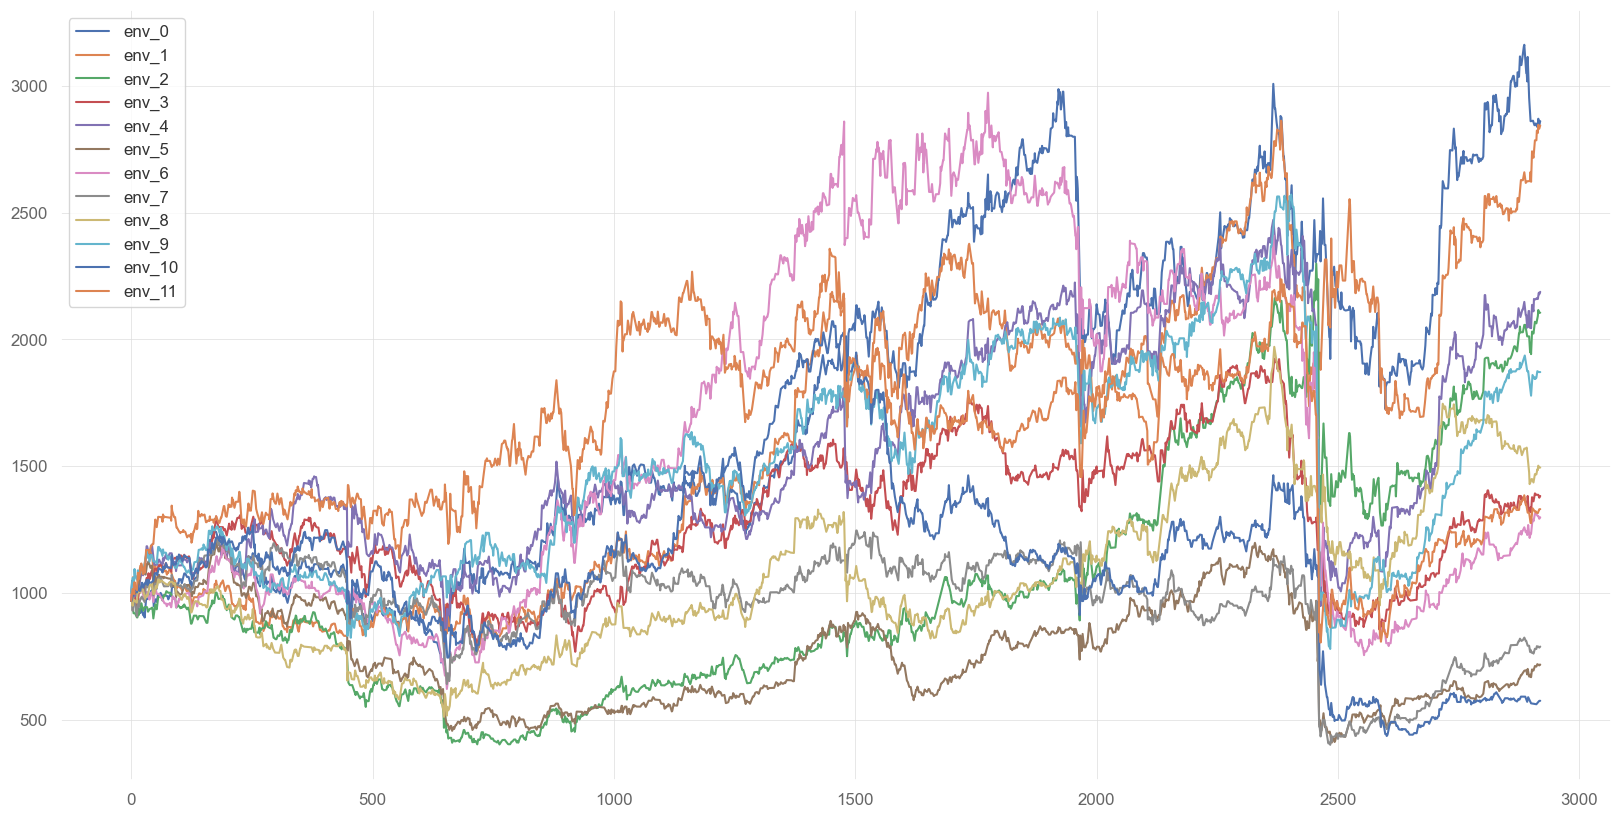

In [34]:
# results.tail(1000).plot(figsize=(20, 10))
results.plot(figsize=(20, 10))



                           Strategy
-------------------------  ----------
Start Period               2012-05-21
End Period                 2024-01-12
Risk-Free Rate             0.0%
Time in Market             52.0%

Cumulative Return          173.01%
CAGR﹪                     6.13%

Sharpe                     0.49
Prob. Sharpe Ratio         95.19%
Smart Sharpe               0.48
Sortino                    0.72
Smart Sortino              0.7
Sortino/√2                 0.51
Smart Sortino/√2           0.49
Omega                      1.13

Max Drawdown               -42.79%
Longest DD Days            1003
Volatility (ann.)          23.28%
Calmar                     0.14
Skew                       0.11
Kurtosis                   13.7

Expected Daily %           0.03%
Expected Monthly %         0.71%
Expected Yearly %          8.03%
Kelly Criterion            5.96%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.37%
Expected Shortfall (cVaR)  -2.37%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-01-24,2014-12-12,2015-10-23,1003,-42.791784,-39.156966
2,2021-10-12,2022-10-07,2023-10-16,735,-42.645349,-39.100647
3,2020-01-09,2020-06-26,2021-10-08,639,-36.296430,-35.114237
4,2016-07-19,2017-06-15,2017-09-22,431,-18.100228,-16.359413
5,2015-11-27,2016-01-15,2016-06-28,215,-17.368164,-16.859808


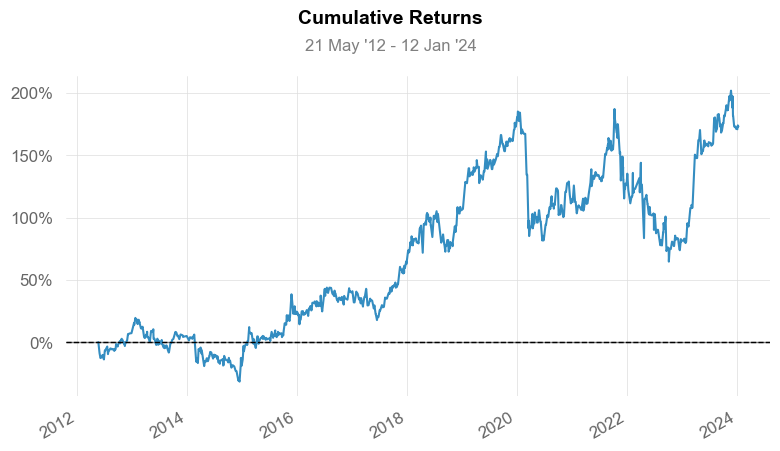

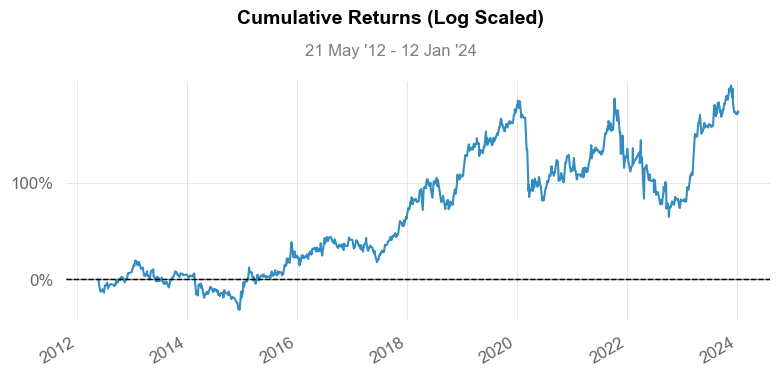

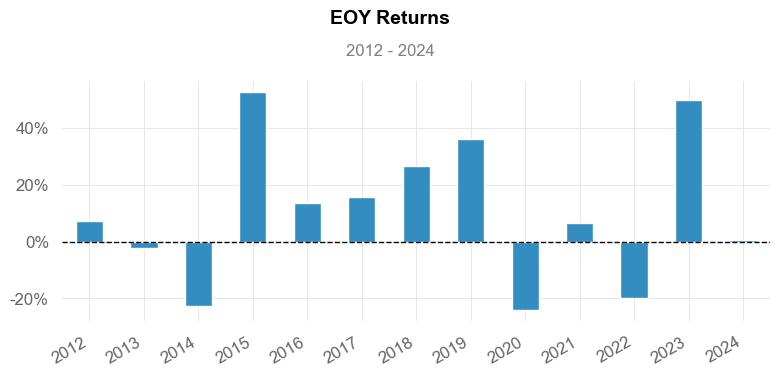

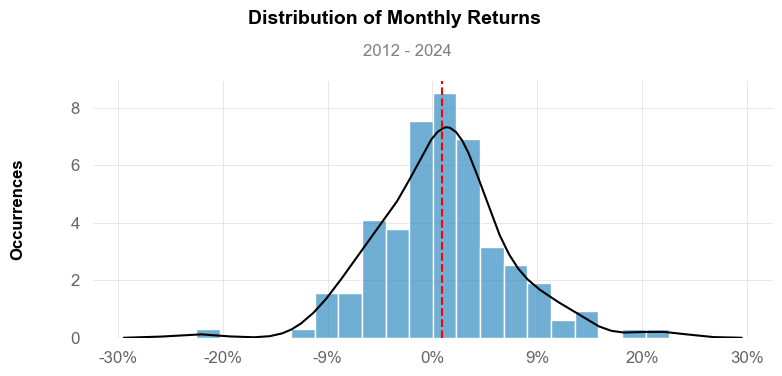

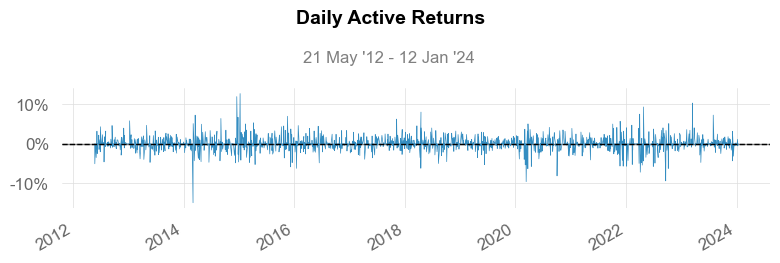

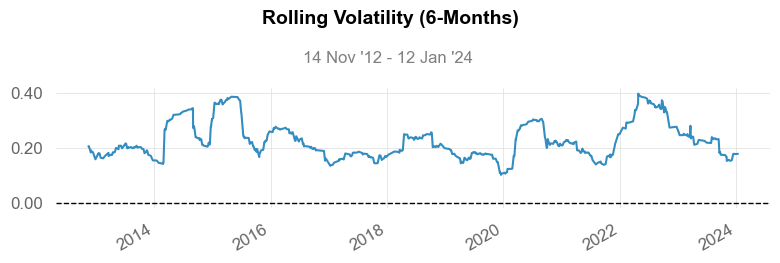

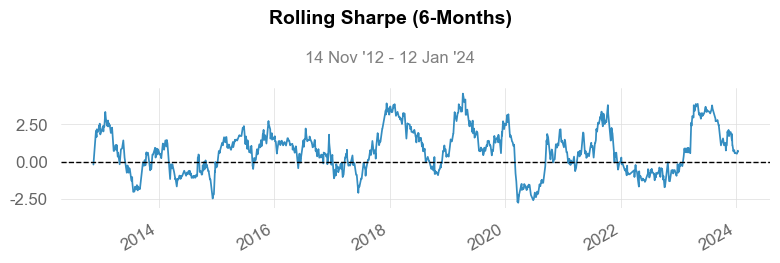

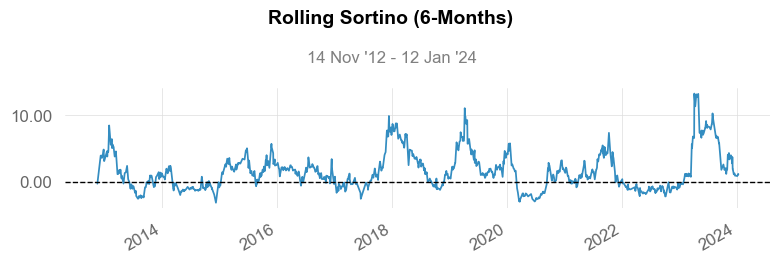

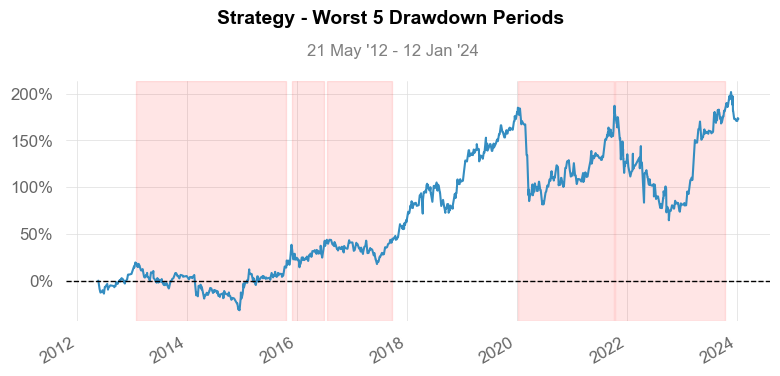

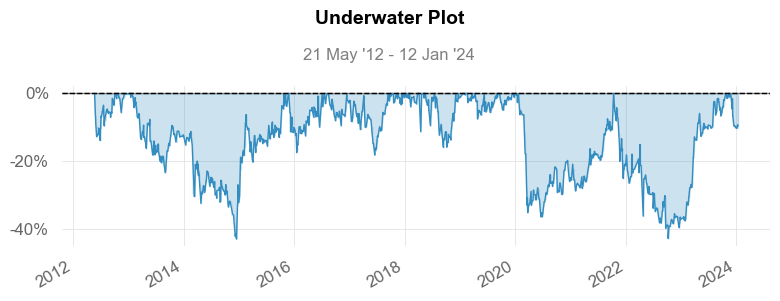

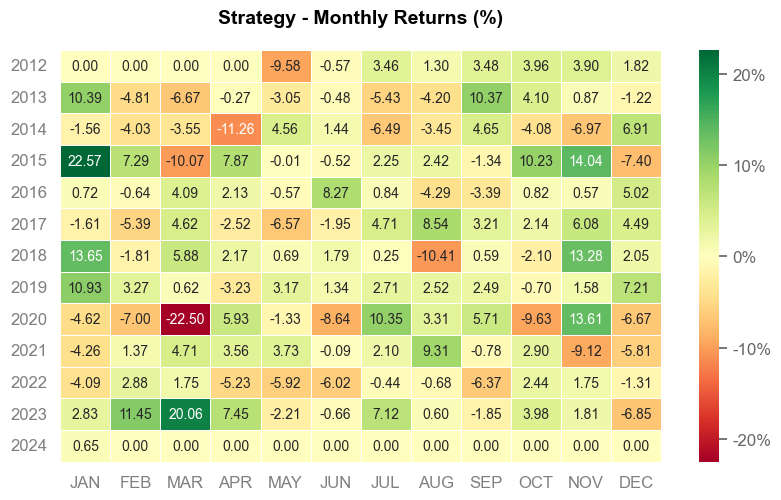

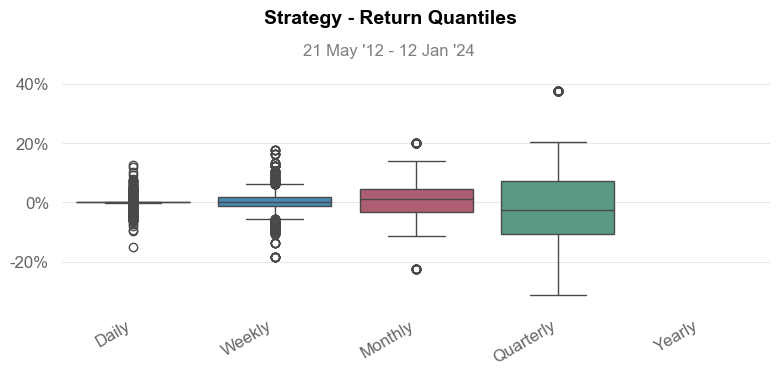

In [27]:
qs.extend_pandas()

net_worth = pd.Series(results['env_0'].values, index=df.index[start_index:end_index])
returns = net_worth.iloc[1:]
qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')

In [ ]:
# env = make_vec_env(
#     lambda: env_maker(),
#     n_envs=num_cpu,
#     seed=0,
#     vec_env_cls=DummyVecEnv
# )
# # env = DummyVecEnv([lambda: gym.make("HalfCheetahBulletEnv-v0")])
# env = VecNormalize.load(stats_path, env)
# env.training = False
# env.norm_reward = False


# # Load the agent
# model = PPO.load(f"{log_dir}/ppo_halfcheetah", env=env)

# obs = env.reset()
# results = []
# while True:
#     action, state = model.predict(obs)
#     obs, reward, done, info = env.step(action)
#     profit = {f'env_{num}': float(i["total_profit"]) for num, i in enumerate(info)}
#     results.append(profit)
#     if done.all():
#         break
# results = pd.DataFrame(results)

AttributeError: 'DummyVecEnv' object has no attribute 'set_venv'

In [18]:

env.training = False
env.norm_reward = False


# Load the agent
model = PPO.load(f"{log_dir}/ppo_halfcheetah", env=env)

obs = env.reset()
results = []
while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    profit = {f'env_{num}': float(i["total_profit"]) for num, i in enumerate(info)}
    results.append(profit)
    if done.all():
        break
results = pd.DataFrame(results)

AttributeError: 'DummyVecEnv' object has no attribute 'set_venv'